---
title: "US Treasury Par Yield Curve Rates Analysis"
author: Samantha Pang
date: Oct 2025
format: 
  html:
    code-fold: true
---

### Let's get started!
This analysis is performed using Python in a Jupyter Notebook environment. Ensure you have the following libraries installed:

* pandas
* datetime
* numpy
* requests
* matplotlib
* beautifulsoup4
* seaborn
* matplotlib

### Extracting the Data via Web Scraping
Data is scrapped from the [U.S. Department of the Treasury](https://home.treasury.gov/policy-issues/financing-the-government/interest-rate-statistics/selected-interest-rates-historical-data).
Date range: 1990 to Present

Use the first URL to inspect the table structure, and get the table headings, then loop through all the URLs to get the table data.

In [1]:
from bs4 import BeautifulSoup as BS
import requests as req
import datetime
import pandas as pd
import numpy as np

urls=[]
url = "https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_yield_curve&field_tdr_date_value=xxxx"

start_year = 1990
end_year = datetime.date.today().year

years = [str(yr) for yr in range(start_year, end_year+1)]

for year in years:
    urls.append(url.replace('xxxx', year))

# inspect the first URL to get the table headings
html_text = req.get(urls[0]).text
soup=BS(html_text, 'html.parser')

print('Scrapping from website:', soup.title.text)
print(f'This script is to scrap US Treasury Rate data from {start_year} to {end_year}.')

# column headings
headings = []
# table = soup.find('table', class_ = 'usa-table views-table views-view-table cols-26') 
# table_rows = table.find_all('tr')

for item in soup.find_all('th'):
    headings.append(item.text)
# print('Table headings <th>:', headings)

# now scrap all the table data/ td from all the URLs
all_rows = []
for url in urls:
    html_text = req.get(url).text
    soup = BS(html_text, 'html.parser')
    table_rows = soup.find_all('tr')               
    for tr in table_rows[1:]:
        td = tr.find_all('td')
        row=[i.text.strip('\n') for i in td]       #i is each td element, i.text is to find all text in that i, .strip to remove entries starts with \n
        all_rows.append(row)
df=pd.DataFrame(data=all_rows, columns=headings)

# df.to_csv('raw_US_Treasury_Rates.csv', index=False)

Scrapping from website: Resource Center | U.S. Department of the Treasury
This script is to scrap US Treasury Rate data from 1990 to 2025.


### Reviewing and Cleaning the Data

Inspecting dataframe via `df.describe()`, `df.info()` and `df.head()`. There are a few things to clean up:

1. Remove leading and trailing spaces
2. Replace all 'N/A' with NaN
3. Drop columns with all NaN values
4. convert the 'Date' column to datetime format
5. convert the rest of the columns to float

##### All done! Ready for analysis.

In [2]:
# display(df.describe(), df.head())
# noticed there are space in N/A cell, 
# print("N/A cell: '", df['20 YR'][0], "'")
# remove all blank spaces in the dataframe, except headers
clean_df = df.iloc[:,:].map(lambda x:x.strip())
# converting to lower case, if cell equals to 'n/a', then replace with empty string
clean_df = clean_df.map(lambda x:np.nan if (x.lower() == 'n/a' or x =='') else x)
# dropping all columns with all NaN values
clean_df.dropna(axis=1, how='all', inplace=True)
# change Date column to datetime and the rest to float
clean_df[clean_df.columns[0]] = pd.to_datetime(clean_df[clean_df.columns[0]])
for col in clean_df.columns[1:]:
    clean_df[col] = clean_df[col].astype(str).astype(float)
# clean_df.info()
# clean_df.head()

### Initial observations
#### I choose you, Seaborn and Matplotlib!
#### Data Distribution

Utilizing seaborn and matplotlib, we will visualize the trends and distribution in the U.S. Treasury Par Yield Curve Rates over time.

Box plots allows us to view the distribution of rates for each maturity period.
We can also observe that the short term rates has generally a lower rate than the long term rates, which is expected.

1.5Mo and 4Mo maturity rate have significantly smaller range of data. Upon review, it appears that the 1.5Mo and 4Mo maturity rates were only added to the dataset in recent years, which has less data points compared to other rates. 

[Text(0, 0.5, '')]

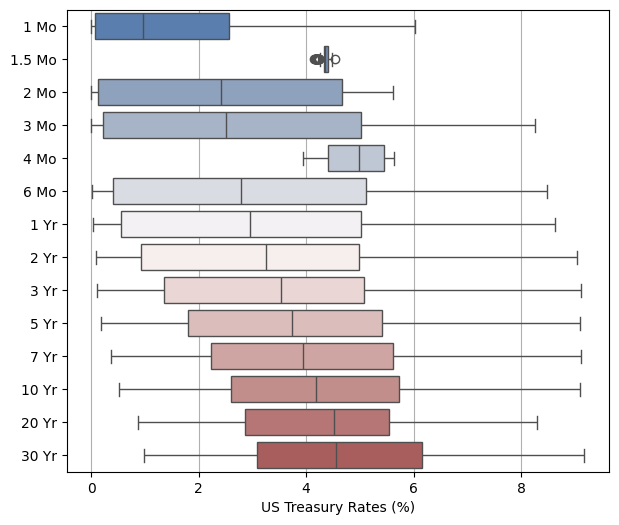

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Melt df to long format
data = clean_df.melt(id_vars='Date', var_name='Series', value_name='Value')
data.dropna(inplace=True)

f, ax = plt.subplots(figsize=(7, 6))
# Plot the orbital period with horizontal boxes, vlag - blue/pink diverging color palette
sns.boxplot(
    data, x="Value", y="Series", hue="Series", palette="vlag"
)

ax.set_xlabel("US Treasury Rates (%)")
ax.xaxis.grid(True)
ax.set(ylabel="")

#### Trends Over Time

The line chart below shows the trends of different maturity rates from 1990 to 2024 are generally trending down. Unexpected upward spikes starting around 2021, likely due to economic recovery post-pandemic.

Moreover, the short-term rates (1 month, 3 month, 6 month, 1 year) are more volatile, while the long-term rates (10 year, 20 year, 30 year) are more stable. There are a few period that the short-term rates spike above the long-term rates, indicating an inverted yield curve, which we will explore this further.

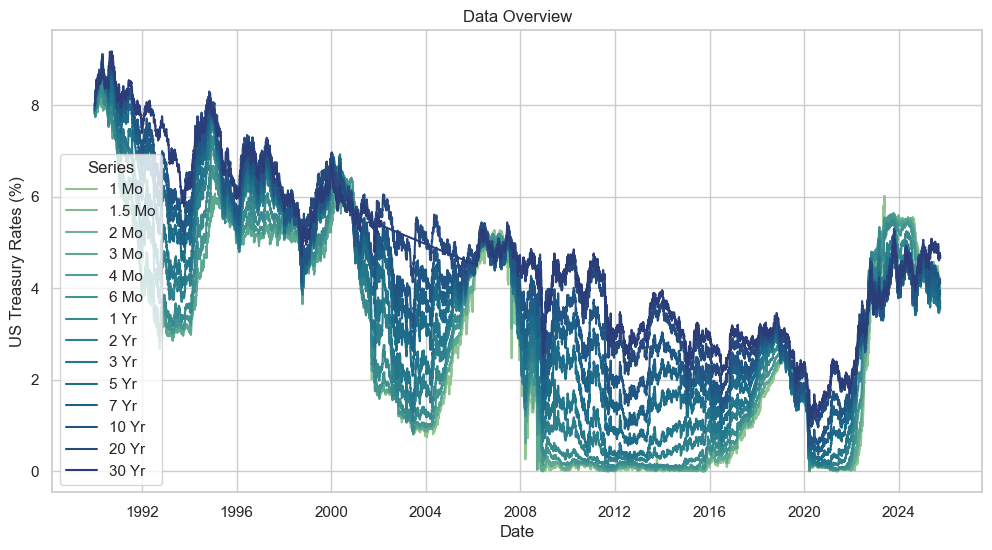

In [4]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x='Date', y='Value', hue='Series', palette='crest')
plt.title("Data Overview")
plt.ylabel("US Treasury Rates (%)")
# plt.
plt.show()

### What is Inverted Yield Curve?

"When short-term rates are higher than long-term rates."

Economists use the yield curve, which compares the interest rates difference bweteen "10-year and 3-month" or "10-year and 2-year" treasury rate, to determine if short-term investments are more profitable than long-term ones. When the yield curve inverts and the difference drops below zero, it serves as a warning sign of an impending recession.

The assumption of recession is supported by the last 30 years of invasion occurrences.
Recession happened in early 2000 (dot-com bubble), 2007-2009 (housing bubble), and 2020 (pendemic). The 3 recessions mentioned experienced a decrease below 0.

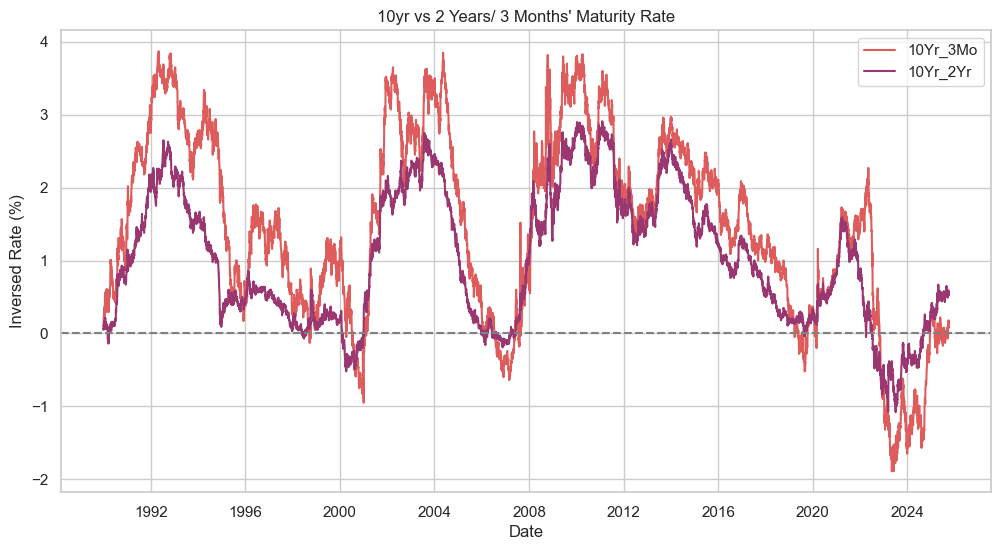

In [5]:
#calculate the inversed rate
clean_df['10Yr_3Mo'] = clean_df['10 Yr']-clean_df['3 Mo']
clean_df['10Yr_2Yr'] = clean_df['10 Yr']-clean_df['2 Yr']

data = clean_df.melt(id_vars='Date', var_name='Series', value_name='Value')
data.dropna(inplace=True)
data = data[data['Series'].isin(['10Yr_3Mo', '10Yr_2Yr'])]

plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x='Date', y='Value', hue='Series', palette='flare')
plt.title("10yr vs 2 Years/ 3 Months' Maturity Rate")
plt.ylabel("Inversed Rate (%)")
plt.legend(loc="upper right")
plt.axhline(y=0, color='grey',linestyle='--')
plt.show()

### Principal Component Analysis (PCA) 

#### Standardize df and Covariance Matrix Heatmap

PCA allows us to reduce the dimensionality of our dataset while retaining most of the variance. This is particularly useful when dealing with datasets that have many correlated variables, as it helps to identify the underlying structure and patterns in the data.

Viewing the covariance matrix, we can see that the short-term rates (1Mo, 3Mo, 6Mo, 1Yr) are highly correlated with each other, as are the long-term rates (10Yr, 20Yr, 30Yr). However, there is a lower correlation between short-term and long-term rates, which is expected given their different sensitivities to economic conditions.

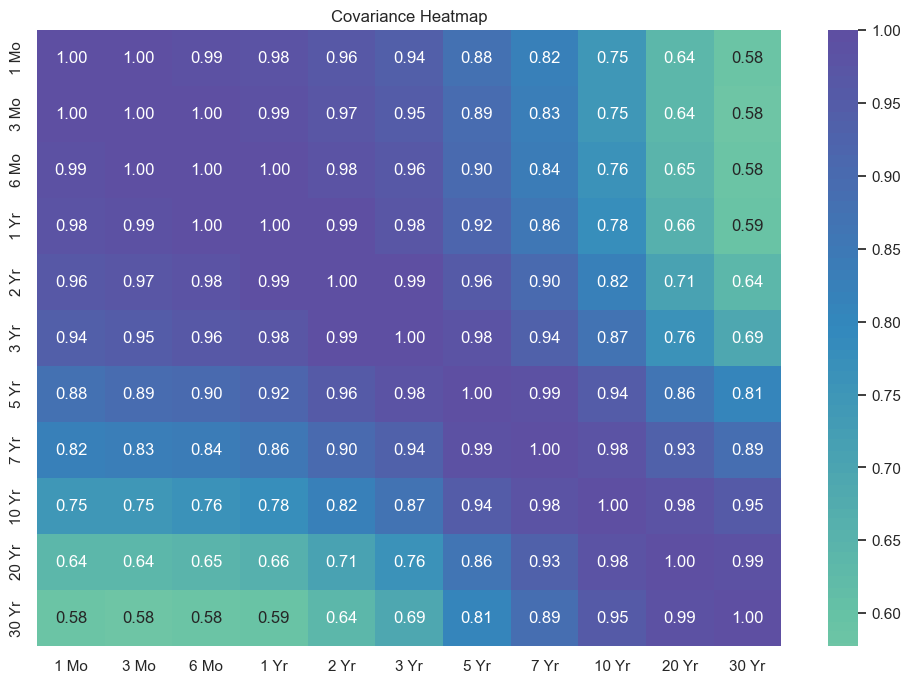

In [6]:
from sklearn.preprocessing import StandardScaler 
import numpy.linalg as LA

data = clean_df[['Date', '1 Mo', '3 Mo', '6 Mo', '1 Yr',
                 '2 Yr', '3 Yr', '5 Yr', '7 Yr', '10 Yr', '20 Yr', '30 Yr']].copy()
data.dropna(inplace=True)
data = data.set_index('Date')
colnames=list(data.columns)
# standardize df
sc=StandardScaler()
data=sc.fit_transform(data)
data=pd.DataFrame(data)

data.columns = colnames

# covariance matrix
cov=pd.DataFrame.cov(data)

plt.figure(figsize=(12,8))
sns.heatmap(cov, cmap="Spectral", center=0, annot=True, fmt=".2f")

plt.title("Covariance Heatmap")
plt.show()

You can see that PC1 and PC2 explain most of the variance in the data (98.7% combined). The majority of the information in the original dataset can be captured in just two dimensions, which is a significant reduction from the original 11 dimensions.

PC1 has coefficients that are all positive and relatively similar in magnitude (~0.3). It represents a general trend across all maturity rates. In contrast, First 6 of the PC2 coefficients are negative, and the last 5 are positive. This suggests PC2 captures the contrast between short-term and long-term rates.

In [7]:
eval, evec = LA.eig(cov)
for i in range(5):
    print('The PC{} is {}, its variance is {}, % variance is {}%, % cumulative variance is {}% '.format(
        i+1
        , np.round(evec[:, i],2)
        , round(eval[i],2)
        , round(eval[i]/eval.sum()*100,2)
        , round(eval[:i+1].sum()/eval.sum()*100,2)))
    

The PC1 is [0.3  0.3  0.31 0.31 0.31 0.32 0.32 0.31 0.3  0.27 0.26], its variance is 9.61, % variance is 87.34%, % cumulative variance is 87.34% 
The PC2 is [-0.29 -0.29 -0.28 -0.26 -0.2  -0.12  0.06  0.19  0.33  0.46  0.52], its variance is 1.25, % variance is 11.37%, % cumulative variance is 98.71% 
The PC3 is [ 0.44  0.33  0.19  0.01 -0.25 -0.38 -0.41 -0.31 -0.07  0.19  0.38], its variance is 0.12, % variance is 1.06%, % cumulative variance is 99.77% 
The PC4 is [ 0.54  0.13 -0.25 -0.44 -0.31 -0.08  0.27  0.38  0.14 -0.29 -0.13], its variance is 0.01, % variance is 0.13%, % cumulative variance is 99.89% 
The PC5 is [-0.05 -0.06 -0.06  0.03  0.15  0.11  0.01 -0.04 -0.05 -0.7   0.68], its variance is 0.01, % variance is 0.05%, % cumulative variance is 99.95% 


#### PCA Biplot
We will analyze are 2 main components in the biplot: the arrows vs the points.
The arrows represent the original variables (maturities), while the points represent the observations (dates).

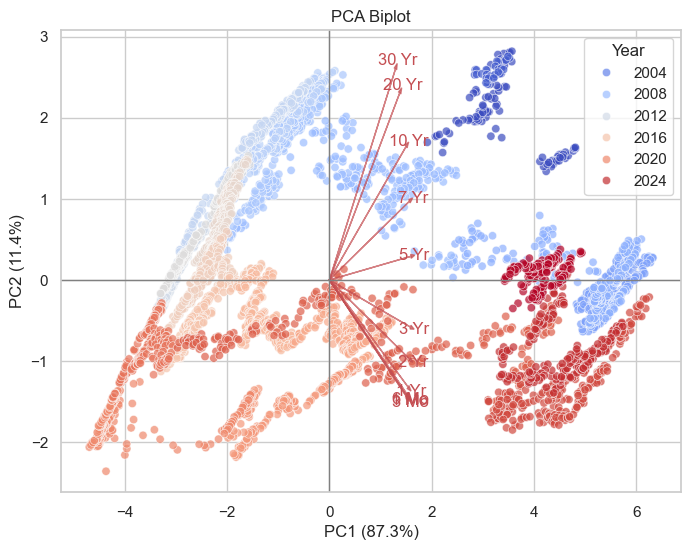

In [ ]:
PCs = np.dot(data, evec[:, :2])  # matrix multiplication: 11 variables (maturities) * weights (PC1, PC2)

data1 = clean_df[['Date', '1 Mo', '3 Mo', '6 Mo', '1 Yr',
                 '2 Yr', '3 Yr', '5 Yr', '7 Yr', '10 Yr', '20 Yr', '30 Yr']].copy()
data1.dropna(inplace=True)
data1 = data1[['Date']]
data1['Year'] = clean_df['Date'].dt.year
data1.reset_index(drop=True, inplace=True)
pc_df = pd.DataFrame(PCs, columns=['PC1', 'PC2'])
pc_df = pd.concat([data1, pc_df], axis = 1)

plt.figure(figsize=(8,6))
sns.scatterplot(data = pc_df, x='PC1', y='PC2', alpha=0.7, hue = 'Year', palette='coolwarm')

# Add arrows for variable loadings
for i, var in enumerate(data.columns):
    #arrow start from 0,0, expand at the direction of PC1 and 2 for each maturity, *5 to make the arrows visible 
    plt.arrow(0, 0, evec[i,0]*5, evec[i,1]*5, color='r', alpha=0.7, head_width=0.05)
    plt.text(evec[i,0]*5.2, evec[i,1]*5.2, var, color='r', ha='center', va='center')

# 87.3% data explained by PC1 and 11.4% explained by PC2
plt.xlabel("PC1 (%.1f%%)" % (eval[0]/eval.sum()*100))
plt.ylabel("PC2 (%.1f%%)" % (eval[1]/eval.sum()*100))
# horizontal and vertical lines at 0, y and x
plt.axhline(0, color='grey', linewidth=1)
plt.axvline(0, color='grey', linewidth=1)
plt.title("PCA Biplot")
plt.grid(True)
plt.show()

##### Points and Clusters
Each point is weighted value of PC1 and PC2 for each observation (date). The position of the points indicates how the observations relate to the PC. The  points are colored by year with a gradient from blue (earlier years) to red (later years). Each year has a distinct cluster, and the clusters allow us to observe how the observations change over time in relation to the PC. 

##### Arrows (Loadings)
The arrows (loadings) represents the original variables (maturities). The arrows are pinned at the origin (0,0). The direction represents how each variable contributes to the PC, while the length indicates the strength of the contribution.

###### Length of Arrows
The length of the arrows provides insight into the importance of each variable in explaining the variance captured by the PC. 30Yr has the longest arrow, indicating that the strongest influence on the PC1. In contrast, 5Yr has a shorter arrow, suggesting that lesser contribution to the variance.

###### Angles of Arrows 
The arrows for 1Mo, 3Mo, 6Mo, and 1Yr are close together, indicating that these short-term rates are highly correlated, same as arrows of 10Yr, 20Yr, and 30Yr for long-term rates. 
The arrows for 1Mo and 30Yr point in nearly opposite directions, suggesting a negative correlation between short-term and long-term rates.
The arrows for 10Yr and 3Yr are nearly perpendicular, which indicates that the variables are uncorrelated.

###### Direction of Arrows
<!-- Bottom axis: PC1 score.
Left axis: PC2 score.
Top axis: loadings on PC1.
Right axis: loadings on PC2. -->
20Yr and 30Yr have high positive loadings on PC1 as they are closer to top axis/ loadings of PC1. 1Mo and 3Mo have lower loadings on PC1 smaller impact on the overall level of interest rates.
None of the maturities have high loadings on PC2, indicating that PC2 captures the contrast between short-term and long-term rates rather than being dominated by any single maturity.

### Conclusion

<!-- ### Conclusion
to do list 
- make interactive plot with plotly for biplot
- write conclusion
- quarto website
- deploy to github pages
- how to make it look cute? -->
